<h1>Table of contents<span class="tocSkip"></span></h1>
</ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preprocessing</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data analysis</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Models training</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models testing</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Final conclusions</a></span></li></ul>

#  Taxi bookings predictions

The company "Chetenkoe taxi" collected historical data on taxi orders at airports. To attract more drivers during peak load, you need to predict the number of taxi orders for the next hour. Build a model for such a prediction.

The value of the *RMSE* metric in the test sample should be no more than 48.

You need to:

1. Download the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.


The data is in the file `taxi.csv'. The number of orders is in the `num_orders` column.

## 1.  Data preprocessing

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=True)
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Let's look at the general information about the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Let's check the monotony of the function

In [5]:
df.index.is_monotonic

True

<div style="font-size: 20px">
    

**Resampling the data for 1 hour**

Let's resample for 1 hour and sum up the values when grouping.

In [6]:
df = df.resample('1H').sum()
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
df.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


<div style="font-size: 20px">
    

**Intermediate conclusion:**

Data represent a monotonous time series of taxi orders from 2018-03-01 to 2018-08-31 (interval - 10 min.). As a result of the initial processing, data was resampled up to 1 hour, it is assumed that the new table indicates the number of new summed orders for 1 hour, and not 10 minutes.

## 2.  Data analysis

Let's analyze the trend, seasonality and the residuals of our dataset.

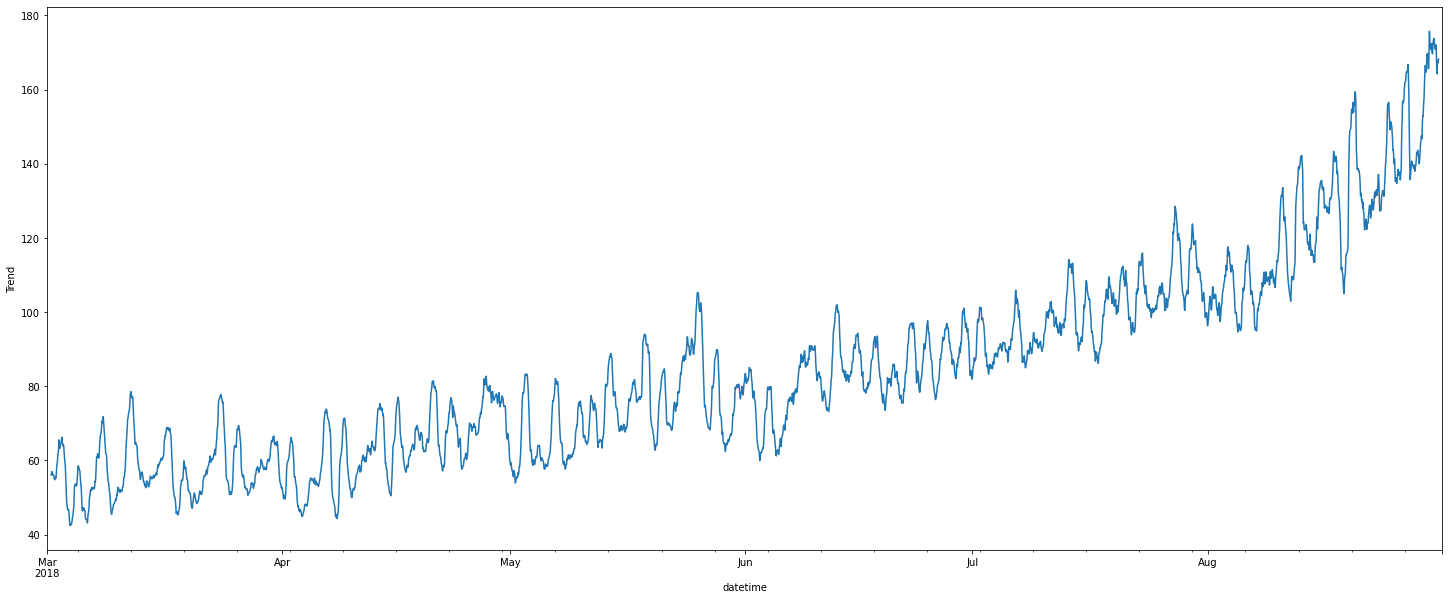

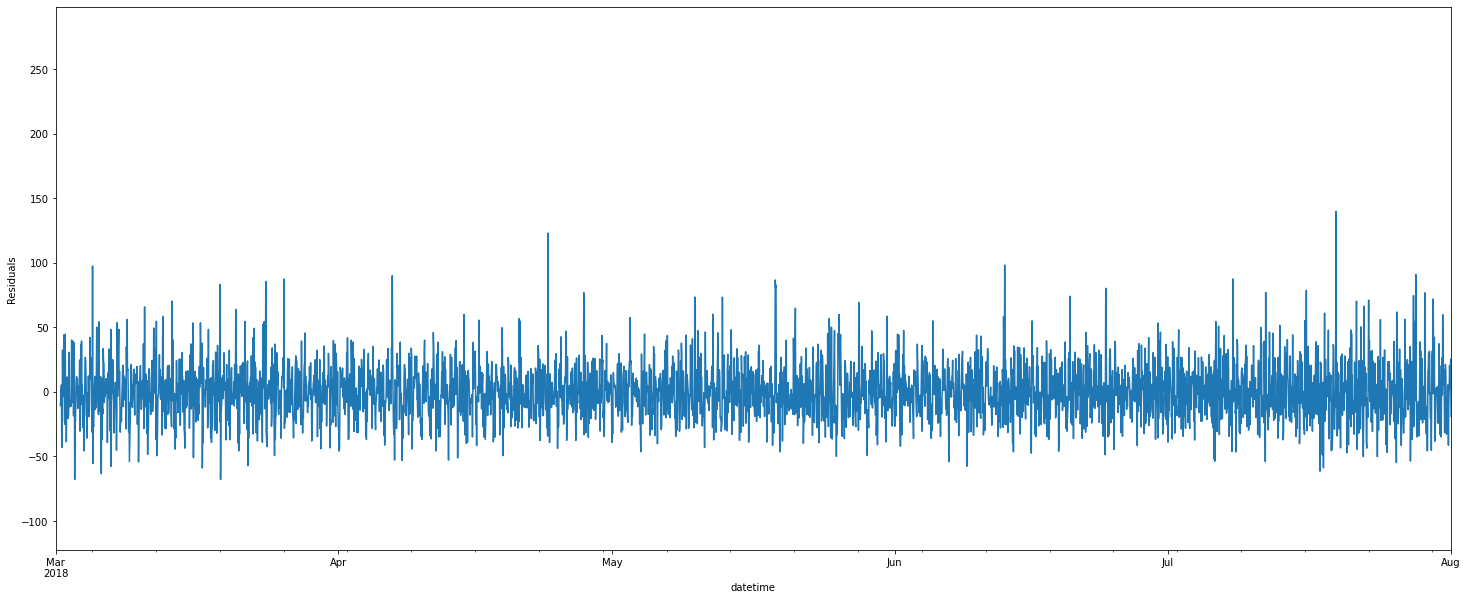

In [9]:
decomposed = seasonal_decompose(df.num_orders)

start_date = '2018-03'
end_date = '2018-08'

trend = decomposed.trend
trend.plot(figsize=(25,10))
plt.ylabel('Trend')
plt.show()

# Residuals
resid = decomposed.resid
resid.plot(figsize=(25,10), xlim=(start_date, end_date))
plt.ylabel('Residuals')
plt.show()

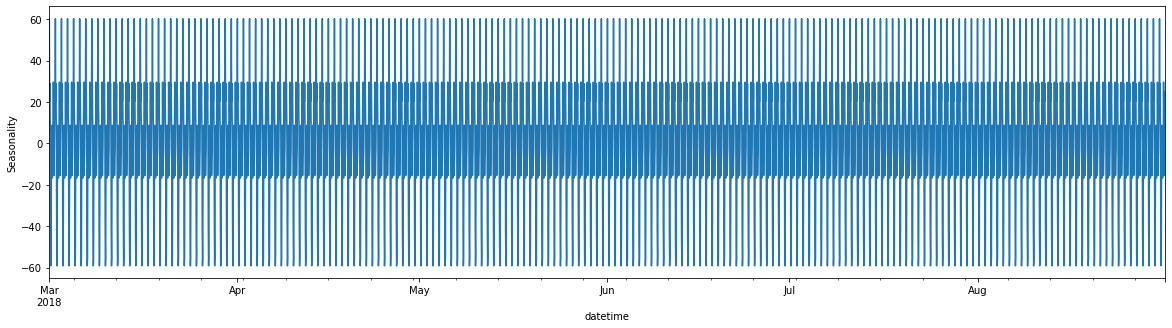

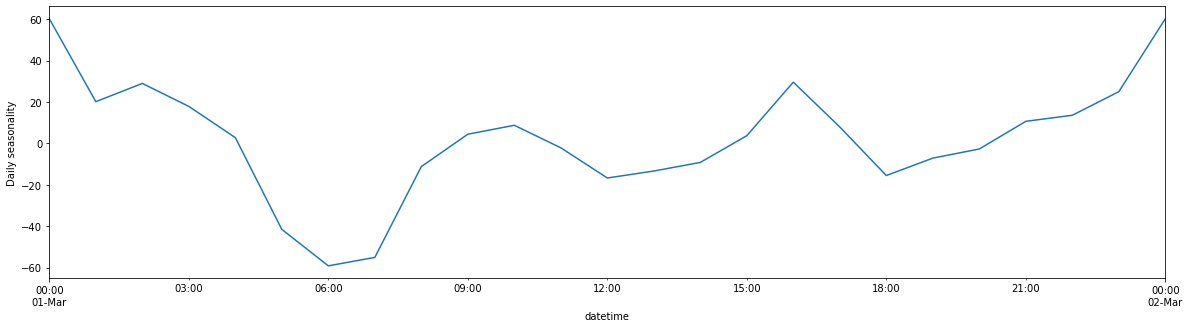

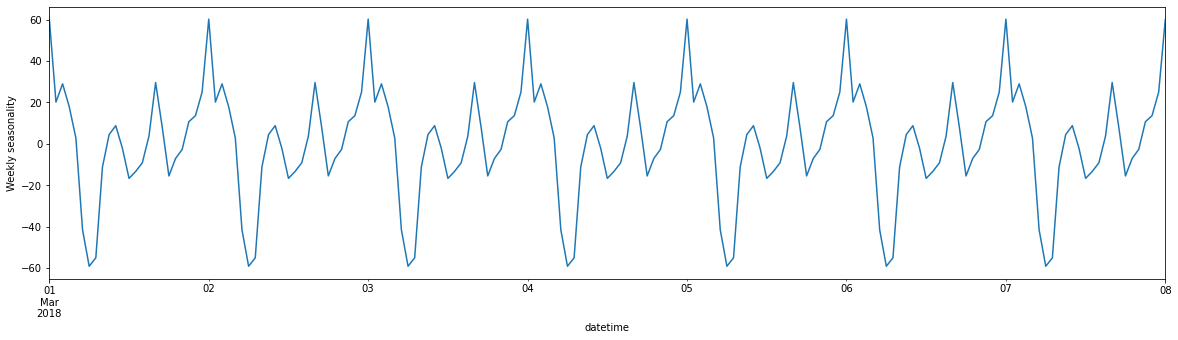

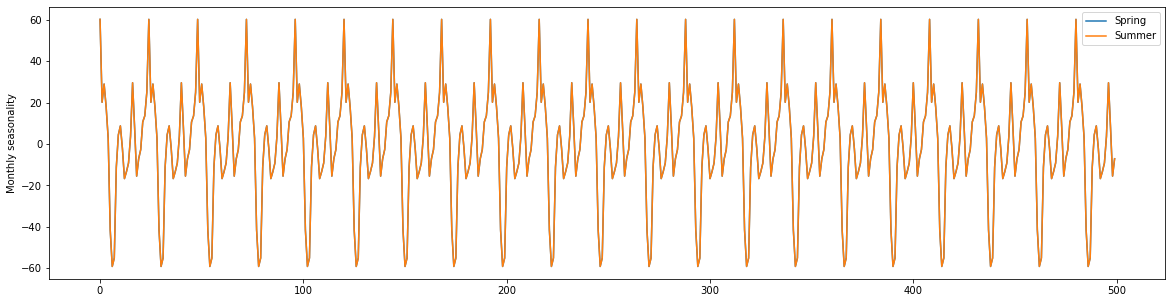

In [10]:
seasonal = decomposed.seasonal
seasonal.plot(figsize=(20,5))
plt.ylabel('Seasonality')
plt.show()

start_day = '2018-03-01'
end_day = '2018-03-02'
seasonal.plot(figsize=(20,5), xlim=(start_day,end_day))
plt.ylabel('Daily seasonality')
plt.show()

start_day = '2018-03-01'
end_day = '2018-03-08'
seasonal.plot(figsize=(20,5), xlim=(start_day, end_day))
plt.ylabel('Weekly seasonality')
plt.show()

first_seasonal = seasonal[:'2018-05']
second_seasonal = seasonal['2018-06':'2018-08']
pd.DataFrame({
    'Spring':first_seasonal.values[:500],
    'Summer':second_seasonal.values[:500]
             }).plot(figsize=(20,5))
plt.ylabel('Monthly seasonality')
plt.show()

Let's estimate the change in the level of orders by day during March 2018.

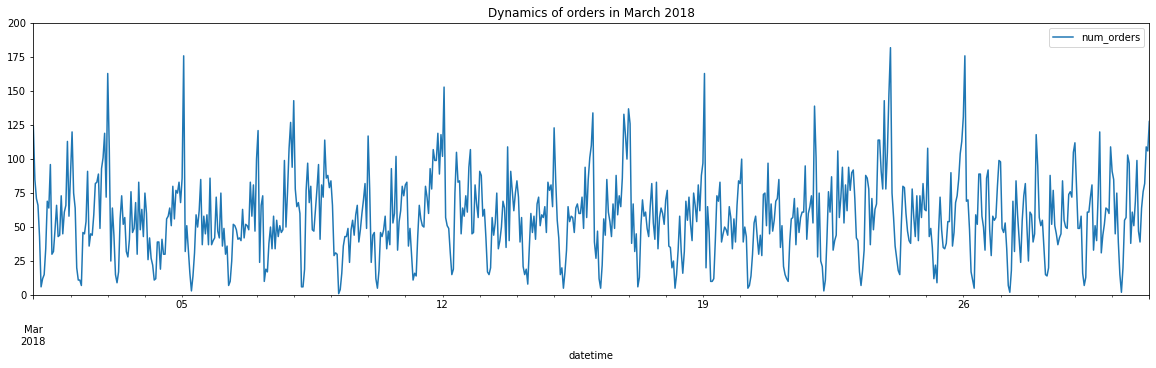

In [11]:
start_date = '2018-03-01'
end_date = '2018-03-31'
df.plot(figsize=(20,5), xlim=(start_date, end_date), ylim=(0,200))
plt.title('Dynamics of orders in March 2018')
plt.show()

Let's evaluate the dynamics for the entire period.

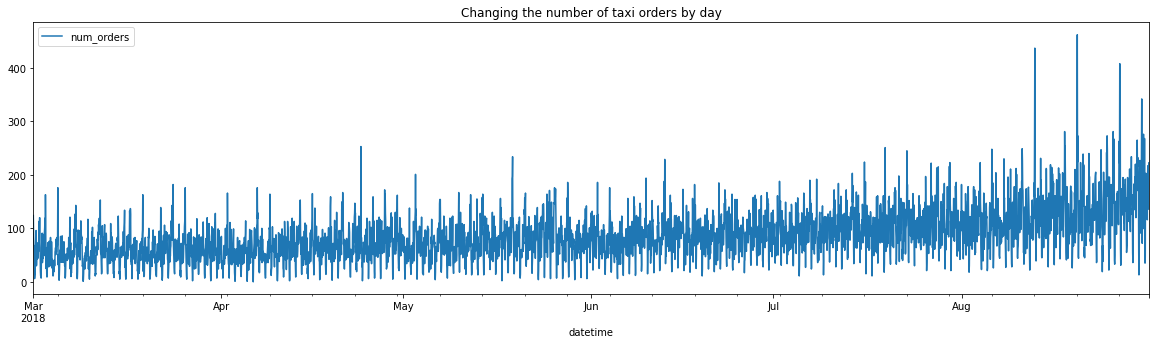

In [12]:
df.plot(figsize=(20,5))
plt.title('Changing the number of taxi orders by day')
plt.show()

<div style="font-size: 20px">
    

**Intermediate conclusion:**

Analysis of the graphs of the components of the time series due to decomposition into trend, seasonality and residuals, allows us to detect:

1. uptrend;

2. intraday seasonality

3. the largest number of orders falls on the period from 5 to 9 am, as well as from 16:00 to 21:00;

4. spring-summer seasonality, as well as depending on the day of the week is not observed;

5. the change in the average value over time, which indicates its non-stationarity.

Since the trend is upward, the balances are stable, and there is no monthly seasonality, we can talk about a systematic growth of orders month by month.

## 3.  Models training

<div style="font-size: 15px">
    

**Assessment of the impact of the previous parameters**

In [13]:
def make_features(df, max_lag, rolling_mean_size, goal='num_orders'):
    # Let's create features
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df[goal].shift(lag)
        
    df['rolling_mean'] = df[goal].shift().rolling(rolling_mean_size).mean()

In [14]:
temp = df.copy()
make_features(temp, 5, 5)

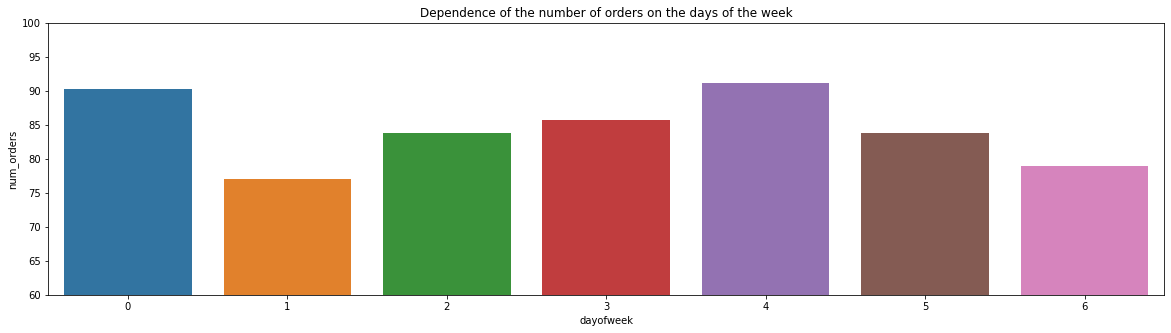

In [15]:
day_pivot = temp.pivot_table(index=['dayofweek'],
                             values='num_orders',
                             aggfunc='mean')
plt.figure(figsize=(20,5))
sns.barplot(x='dayofweek', y='num_orders',
            data=day_pivot.reset_index())
plt.title('Dependence of the number of orders on the days of the week')
plt.ylim(60,100)
plt.show()

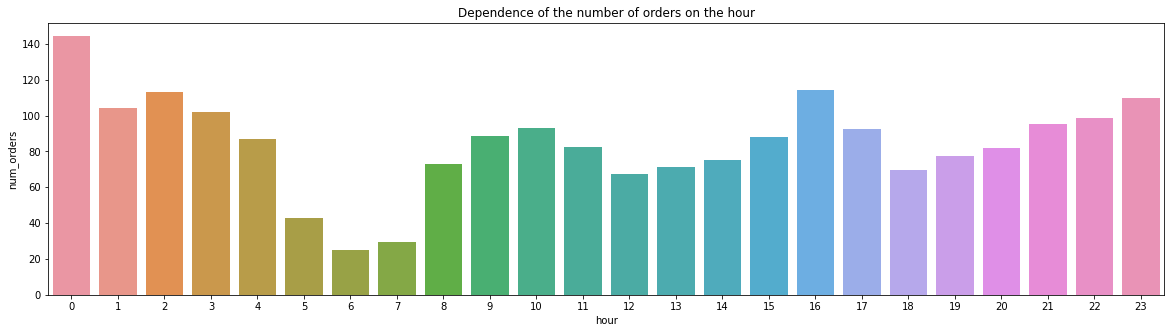

In [16]:
hour_pivot = temp.pivot_table(index=['hour'],
                              values='num_orders',
                              aggfunc='mean')
plt.figure(figsize=(20,5))
sns.barplot(x='hour',y='num_orders',
            data=hour_pivot.reset_index())
plt.title('Dependence of the number of orders on the hour')
plt.show()

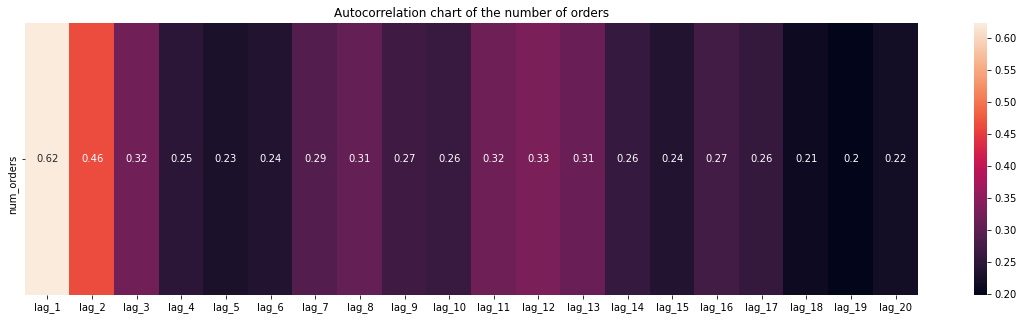

In [17]:
df_for_parse = df.copy()
make_features(df_for_parse, 20, 1)
plt.figure(figsize=(20,5))
sns.heatmap(df_for_parse.drop(['dayofweek', 'hour', 'rolling_mean'], axis=1).dropna().corr()[['num_orders']][1:].T, annot=True)
plt.title('Autocorrelation chart of the number of orders')
plt.show()

<div style="font-size: 15px">
    

**Best model search**

In [18]:
# Let's select the training and test samples
train, test = train_test_split(df,
                              test_size=0.1,
                              shuffle=False)

In [19]:
def build_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    rmse_train = mean_squared_error(y_train, model.predict(X_train)) ** 0.5
    rmse_valid = mean_squared_error(y_val, model.predict(X_val)) ** 0.5
    return (rmse_train, rmse_valid)

Let's evaluate the main machine learning algorithms: linear regression, decision tree, random forest and gradient boosting. For training and subsequent verification, we will divide the initial sample into training, validation and test.

In [20]:
%%time
np.random.seed(1)
stat = pd.DataFrame(columns=['Sliding window size',
                             'Number of previous values',
                             'Model',
                             'RMSE on training sample',
                             'RMSE on validation sample'])

for i, (window, lag) in enumerate(zip(np.random.randint(5, 30, 10), np.random.randint(5, 30, 10))):
    print(str.center(f'({i + 1})', 100, '-'))
    df_for_parse = df.copy()
    
    # We will allocate 90% of the original sample for further work
    df_for_parse, _ = train_test_split(df_for_parse, test_size=0.1, shuffle=False)
    
    # We will add features and delete empty lines
    make_features(df_for_parse, lag, window)
    df_for_parse.dropna(inplace=True)
    
    # Let's highlight the training and validation samples
    train, valid = train_test_split(df_for_parse, shuffle=False)
    
    # Let 's highlight features and target
    X_train = train.drop(['num_orders'], axis=1)
    y_train = train['num_orders']
    X_val = valid.drop(['num_orders'], axis=1)
    y_val = valid['num_orders']
    
    # Linear regression training
    linear_model = LinearRegression()
    linear_rmse_train, linear_rmse_valid = build_model(linear_model,
                                                       X_train, y_train,
                                                       X_val, y_val)
    stat.loc[len(stat)] = [window, lag, linear_model,
                           linear_rmse_train, linear_rmse_valid]
    print('Linear regression is trained')
    
    # Decision tree training
    tree_model_best = None
    rmse_tree_model_train_best = None
    rmse_tree_model_val_best = None
    for max_depth in np.random.randint(5, 200,15):
        tree_model = DecisionTreeRegressor(max_depth=max_depth)
        tree_rmse_train, tree_rmse_valid = build_model(tree_model,
                                                       X_train, y_train,
                                                       X_val, y_val)
        if (tree_model_best is None or
            rmse_tree_model_val_best > tree_rmse_valid):
            tree_model_best = tree_model
            rmse_tree_model_train_best = tree_rmse_train
            rmse_tree_model_val_best = tree_rmse_valid
    stat.loc[len(stat)] = [window, lag, tree_model_best,
                           rmse_tree_model_train_best, rmse_tree_model_val_best]
    print('Decision tree is trained')
    
    # Random forest training
    forest_model_best = None
    rmse_forest_model_train_best = None
    rmse_forest_model_val_best = None
    for max_depth, n_estimators in zip(np.random.randint(5,200,20),
                                       np.random.randint(5,200,20)):
        forest_model = RandomForestRegressor(max_depth=max_depth,
                                             n_estimators=n_estimators)
        forest_rmse_train, forest_rmse_valid = build_model(forest_model,
                                                           X_train, y_train,
                                                           X_val, y_val)
        if (forest_model_best is None or
            rmse_forest_model_val_best > forest_rmse_valid):
            forest_model_best = forest_model
            rmse_forest_model_train_best = forest_rmse_train
            rmse_forest_model_val_best = forest_rmse_valid
    stat.loc[len(stat)] = [window, lag, forest_model_best,
                           rmse_forest_model_train_best,
                           rmse_forest_model_val_best]
    print('Random forest is trained')
    
    # Gradient boosting training
    gbmodel = LGBMRegressor()
    
    gb_model_best = None
    rmse_gb_model_train_best = None
    rmse_gb_model_val_best = None
    for max_depth, n_estimators, learning_rate in zip(np.random.randint(5,200,20),
                                                      np.random.randint(5,30, 20),
                                                      np.random.randint(10,80,20)):
        gb_model = LGBMRegressor(max_depth=max_depth,
                                 n_estimators=n_estimators,
                                 learning_rate=learning_rate / 100)
        gb_rmse_train, gb_rmse_valid = build_model(gb_model,
                                                   X_train, y_train,
                                                   X_val, y_val)
        if (gb_model_best is None or
            rmse_gb_model_val_best > gb_rmse_valid):
            gb_model_best = gb_model
            rmse_gb_model_train_best = gb_rmse_train
            rmse_gb_model_val_best = gb_rmse_valid
    stat.loc[len(stat)] = [window, lag, gb_model_best,
                           rmse_gb_model_train_best,
                           rmse_gb_model_val_best]
    print('Gradient boosting is trained')

------------------------------------------------(1)-------------------------------------------------
Linear regression is trained
Decision tree is trained
Random forest is trained
Gradient boosting is trained
------------------------------------------------(2)-------------------------------------------------
Linear regression is trained
Decision tree is trained
Random forest is trained
Gradient boosting is trained
------------------------------------------------(3)-------------------------------------------------
Linear regression is trained
Decision tree is trained
Random forest is trained
Gradient boosting is trained
------------------------------------------------(4)-------------------------------------------------
Linear regression is trained
Decision tree is trained
Random forest is trained
Gradient boosting is trained
------------------------------------------------(5)-------------------------------------------------
Linear regression is trained
Decision tree is trained
Random fo

In [21]:
stat.sort_values(by='RMSE on validation sample', ascending=True)

,Sliding window size,Number of previous values,Model,RMSE on training sample,RMSE on validation sample
11,17,12,"LGBMRegressor(learning_rate=0.28, max_depth=78...",14.864218,29.636296
10,17,12,"(DecisionTreeRegressor(max_depth=118, max_feat...",7.800952,30.205995
15,13,18,"LGBMRegressor(learning_rate=0.18, max_depth=13...",13.888050,30.229872
7,16,17,"LGBMRegressor(learning_rate=0.3, max_depth=114...",13.287415,30.297830
35,5,23,"LGBMRegressor(learning_rate=0.29, max_depth=63...",12.807855,30.514432
6,16,17,"(DecisionTreeRegressor(max_depth=105, max_feat...",7.760950,30.589166
22,16,23,"(DecisionTreeRegressor(max_depth=117, max_feat...",7.791345,30.597085
18,14,11,"(DecisionTreeRegressor(max_depth=189, max_feat...",7.685566,30.615295
14,13,18,"(DecisionTreeRegressor(max_depth=145, max_feat...",7.810331,30.636466
31,20,10,"LGBMRegressor(learning_rate=0.28, max_depth=16...",13.759372,30.868518


<div style="font-size: 20px">
    

**Intermediate conclusion:**

To improve the accuracy of the machine learning model based on the initial data, the following features have been added:

* day of the week (due to an increase in the share of orders on Monday and Friday);

* hour of the time point (due to an increase in the number of orders in the morning and evening hours);

* time lag (due to the fact that the autocorrelation analysis shows that the number of orders at the current time is moderately correlated with the previous step) - however, it is better to use a larger number of previous points to build forecasts, because they have a correlation with the target time point and on average is 0.3;

* a sliding window factor that allows us to smooth out outliers.

The following machine learning algorithms were used in the training process:

* linear regression;
* decision tree;
* random forest;
* gradient boosting.

The greatest accuracy in the learning process was shown by the gradient boosting model with a lag of 12 and a sliding window size of 17, which should be used on a test sample.

## 4.  Models testing

In [22]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [23]:
# Let's build a basic model with forecasting for the next hour according on the basis of the previous one
df['num_orders'].shift(1)[1:]
print('RMSE with predictions based on the previous value on the training sample:',
     mean_squared_error(train['num_orders'].shift(1)[1:],
                        train['num_orders'][1:])**0.5)
print('RMSE with predictions based on the previous value on the test sample:',
      mean_squared_error(test['num_orders'].shift(1)[1:],
                         test['num_orders'][1:])**0.5)

RMSE with predictions based on the previous value on the training sample: 36.1452484171318
RMSE with predictions based on the previous value on the test sample: 58.91761802963282


In [24]:
# We will set the necessary parameters
df_first = df.copy()
make_features(df_first, 12, 17)
df_first.dropna(inplace=True)

In [25]:
train, test = train_test_split(df_first, shuffle=False, test_size=0.1)

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

In [26]:
gb_model = stat.loc[11, 'Model']
gb_model.fit(X_train, y_train)
predict_train = gb_model.predict(X_train)
predict_test = gb_model.predict(X_test)

train_rmse = mean_squared_error(y_train, predict_train) ** 0.5
test_rmse = mean_squared_error(y_test, predict_test) ** 0.5

print('Accuracy of gradient boosting on the training sample: {:.3f}'.format(train_rmse))
print('Accuracy of gradient boosting on a test sample: {:.3f}'.format(test_rmse))


Accuracy of gradient boosting on the training sample: 17.076
Accuracy of gradient boosting on a test sample: 43.998


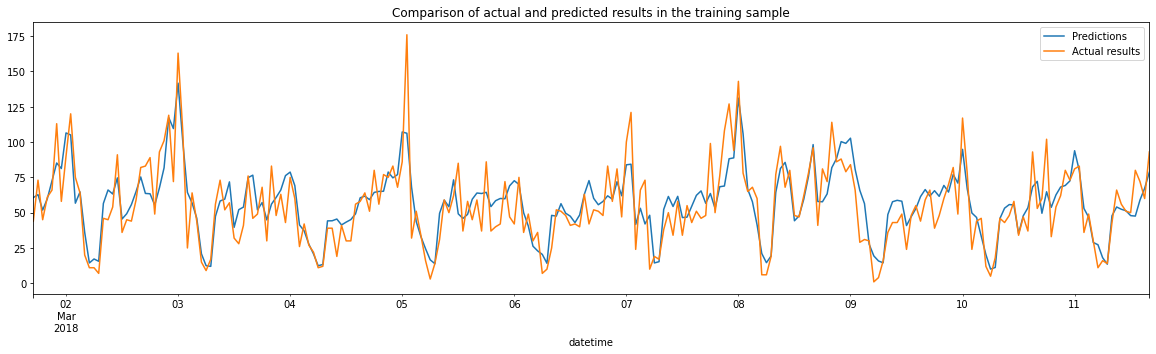

In [27]:
# We will make predictions for 10 days
pd.DataFrame({'Predictions':predict_train,
             'Actual results':y_train})[:240].plot(figsize=(20,5))
plt.title('Comparison of actual and predicted results in the training sample')
plt.show()

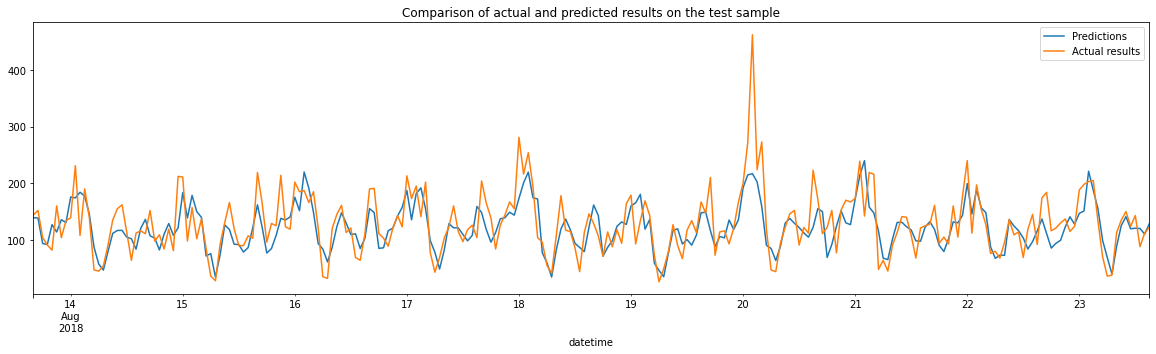

In [28]:
pd.DataFrame({'Predictions':predict_test,
             'Actual results':y_test})[:240].plot(figsize=(20,5))
plt.title('Comparison of actual and predicted results on the test sample')
plt.show()

<div style="font-size: 20px">
    

**5. Final conclusions**

The gradient descent model allows us to build the best predictions(the RMSE metric is approximately 44), which is significantly better than the results obtained using predictions for previous values in the initial data (the RMSE metric is approximately 59).